# Цель лабораторной работы

Изучение линейных моделей, SVM и деревьев решений.

# Задание

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
- одну из линейных моделей (линейную или полиномиальную регрессию при решении задачи регрессии, логистическую регрессию при решении задачи классификации);
- SVM;
- дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.
6. Постройте график, показывающий важность признаков в дереве решений.
7. Визуализируйте дерево решений или выведите правила дерева решений в текстовом виде.

# Ход выполнения работы

In [1]:
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
import numpy as np
import pandas as pd
import math
from operator import itemgetter
from typing import Dict, Tuple
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics._classification import classification_report
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
print('Диабетики:')
print(df[df['diabetes']==1].describe().T)
print('\Недиабетики:')
print(df[df['diabetes']==0].describe().T)

Диабетики:
                          count           mean            std      min  \
age                       125.0      59.418672      10.525180     40.0   
anaemia                   125.0       0.424000       0.496179      0.0   
creatinine_phosphokinase  125.0     570.824000     908.977191     30.0   
diabetes                  125.0       1.000000       0.000000      1.0   
ejection_fraction         125.0      38.016000      11.283719     15.0   
high_blood_pressure       125.0       0.344000       0.476953      0.0   
platelets                 125.0  273978.578160  110584.605487  25100.0   
serum_creatinine          125.0       1.336640       0.840174      0.6   
serum_sodium              125.0     136.160000       5.185899    113.0   
sex                       125.0       0.560000       0.498384      0.0   
smoking                   125.0       0.240000       0.428802      0.0   
time                      125.0     133.344000      80.332284      8.0   
DEATH_EVENT               1

In [6]:
# Данные для дерева решений
tree_data = df
tree_data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Логистическая регрессия

In [7]:
# Разбиение на матрицу объекты-признаки и целевой признак (таргет)
X = df.drop("diabetes", axis=1).values
y = df["diabetes"].values
X, y

(array([[7.500e+01, 0.000e+00, 5.820e+02, ..., 0.000e+00, 4.000e+00,
         1.000e+00],
        [5.500e+01, 0.000e+00, 7.861e+03, ..., 0.000e+00, 6.000e+00,
         1.000e+00],
        [6.500e+01, 0.000e+00, 1.460e+02, ..., 1.000e+00, 7.000e+00,
         1.000e+00],
        ...,
        [4.500e+01, 0.000e+00, 2.060e+03, ..., 0.000e+00, 2.780e+02,
         0.000e+00],
        [4.500e+01, 0.000e+00, 2.413e+03, ..., 1.000e+00, 2.800e+02,
         0.000e+00],
        [5.000e+01, 0.000e+00, 1.960e+02, ..., 1.000e+00, 2.850e+02,
         0.000e+00]]),
 array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
 

In [8]:
# Формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 9)

In [9]:
%%time
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
y_pred_test_log_reg = log_reg.predict(X_test)
y_pred_train_log_reg = log_reg.predict(X_train)
print(classification_report(y_train, y_pred_train_log_reg), classification_report(y_test, y_pred_test_log_reg))

              precision    recall  f1-score   support

           0       0.60      0.95      0.74       157
           1       0.62      0.12      0.20       112

    accuracy                           0.60       269
   macro avg       0.61      0.53      0.47       269
weighted avg       0.61      0.60      0.51       269
               precision    recall  f1-score   support

           0       0.57      0.94      0.71        17
           1       0.50      0.08      0.13        13

    accuracy                           0.57        30
   macro avg       0.54      0.51      0.42        30
weighted avg       0.54      0.57      0.46        30

CPU times: total: 0 ns
Wall time: 36.8 ms


In [10]:
%%time
# Оценка модели с применением кросс-валидации
scores_log_reg = cross_val_score(log_reg, X, y, cv=25)
np.mean(scores_log_reg)

CPU times: total: 188 ms
Wall time: 285 ms


0.5654545454545455

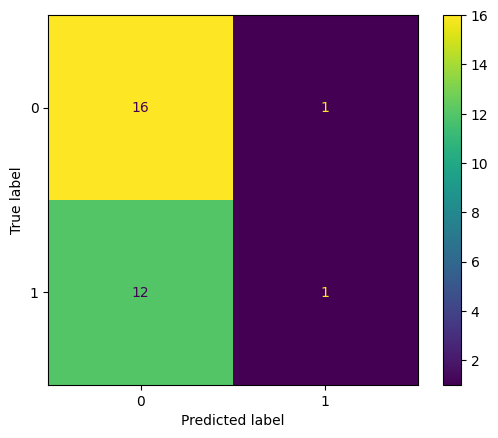

In [11]:
cm_log_reg = confusion_matrix(y_test, y_pred_test_log_reg, labels = log_reg.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_log_reg
)
display_.plot()

## Метод опорных векторов SVM

In [12]:
%%time
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred_test_svc = svc.predict(X_test)
y_pred_train_svc = svc.predict(X_train)
print(classification_report(y_train, y_pred_train_svc), classification_report(y_test, y_pred_test_svc))

              precision    recall  f1-score   support

           0       0.59      0.99      0.74       157
           1       0.67      0.02      0.03       112

    accuracy                           0.59       269
   macro avg       0.63      0.51      0.39       269
weighted avg       0.62      0.59      0.44       269
               precision    recall  f1-score   support

           0       0.57      1.00      0.72        17
           1       0.00      0.00      0.00        13

    accuracy                           0.57        30
   macro avg       0.28      0.50      0.36        30
weighted avg       0.32      0.57      0.41        30

CPU times: total: 0 ns
Wall time: 39.9 ms


C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Xiaomi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [13]:
%%time
# Оценка модели с применением кросс-валидации
scores_svc = cross_val_score(svc, X, y, cv=10)
np.mean(scores_svc)

CPU times: total: 31.2 ms
Wall time: 78.8 ms


0.5819540229885056

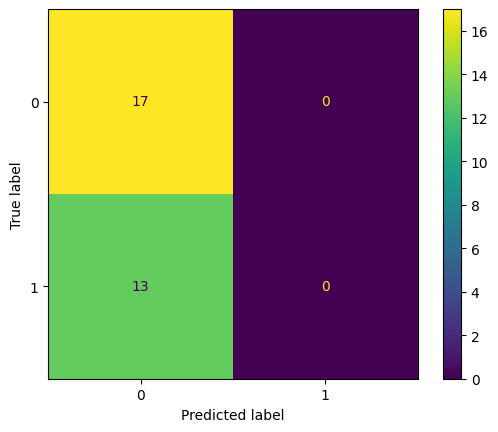

In [14]:
cm_svc = confusion_matrix(y_test, y_pred_test_svc, labels=svc.classes_)
display_ = ConfusionMatrixDisplay(
    confusion_matrix=cm_svc
)
display_.plot()

## Дерево решений

In [15]:
X_tree = tree_data.drop("diabetes", axis=1, inplace=False).values
y_tree = tree_data["diabetes"].values
X_tree, y_tree

(array([[7.500e+01, 0.000e+00, 5.820e+02, ..., 0.000e+00, 4.000e+00,
         1.000e+00],
        [5.500e+01, 0.000e+00, 7.861e+03, ..., 0.000e+00, 6.000e+00,
         1.000e+00],
        [6.500e+01, 0.000e+00, 1.460e+02, ..., 1.000e+00, 7.000e+00,
         1.000e+00],
        ...,
        [4.500e+01, 0.000e+00, 2.060e+03, ..., 0.000e+00, 2.780e+02,
         0.000e+00],
        [4.500e+01, 0.000e+00, 2.413e+03, ..., 1.000e+00, 2.800e+02,
         0.000e+00],
        [5.000e+01, 0.000e+00, 1.960e+02, ..., 1.000e+00, 2.850e+02,
         0.000e+00]]),
 array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
 

In [16]:
# Формирование обучающей и тестовой выборки
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size = 0.1, random_state = 9)

In [17]:
tree = DecisionTreeClassifier(random_state=9, max_depth=4).fit(X_train_tree, y_train_tree)
y_pred_test_tree = tree.predict(X_test_tree)
y_pred_train_tree = tree.predict(X_train_tree)
print(classification_report(y_train_tree, y_pred_train_tree), classification_report(y_test_tree, y_pred_test_tree))
# при стандартном обучении получаем переобучение

              precision    recall  f1-score   support

           0       0.64      0.98      0.77       157
           1       0.89      0.21      0.35       112

    accuracy                           0.66       269
   macro avg       0.76      0.60      0.56       269
weighted avg       0.74      0.66      0.59       269
               precision    recall  f1-score   support

           0       0.62      0.94      0.74        17
           1       0.75      0.23      0.35        13

    accuracy                           0.63        30
   macro avg       0.68      0.59      0.55        30
weighted avg       0.67      0.63      0.57        30



In [18]:
tree.tree_.max_depth, tree.tree_.node_count

(4, 13)

In [19]:
params = {
    'max_depth': range(4, 13)
}

In [20]:
%%time
grid_1 = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=9),
    param_grid=params,
    scoring='accuracy',
    cv=20
)
grid_1.fit(X_tree, y_tree)
grid_1.best_params_, grid_1.best_score_

CPU times: total: 344 ms
Wall time: 602 ms


({'max_depth': 7}, 0.5680952380952381)

In [21]:
tree_rules = export_text(grid_1.best_estimator_, feature_names=list(tree_data.drop("diabetes", axis=1).columns))
HTML('<pre>' + tree_rules + '</pre>')

### Важность признаков

In [22]:
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

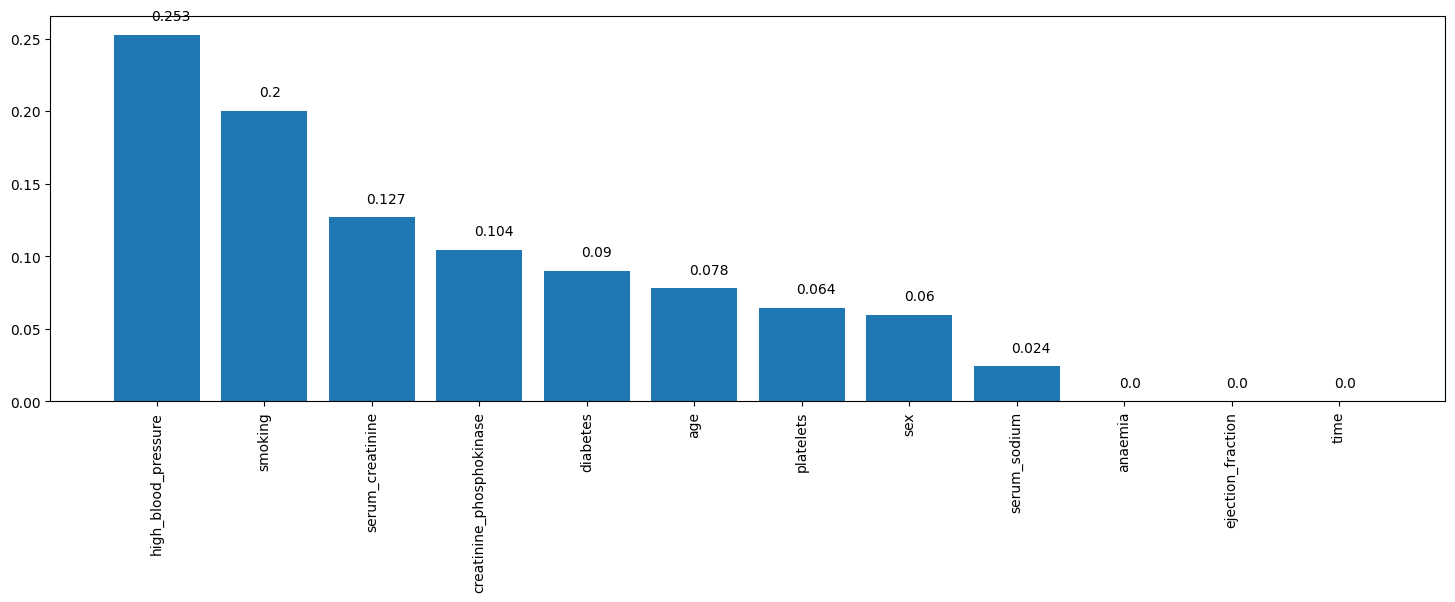

In [23]:
iris_tree_cl_fl, iris_tree_cl_fd = draw_feature_importances(grid_1.best_estimator_, tree_data)